# Back to the Reddit dataset <br>

## This is a copy of Step8 notebook, with similarity threshold == 0.95

After we:

1. Tested few different personality-prediction-by-text tools
2. Generated textual content that highly correlates with high/low openness
3. Trained a logistic regression model to classify texts to high-openness / low-openness
4. Compared the trained model with other models we've trained as well as with the existing tools (1)

We've chose the logistic-regression model that we've trained as the model to work with on the Reddit dataset that we've gathered


## Filter out short texts

To effectively use the model, we need to use only long-enough texts. <br>
We set the threshold as the average length of texts used to train the model, which is **40** tokens.


### Median | AVG Length of posts per community


In [1]:
import os
import json
import statistics

directory = "./data/detailed_filtered_data"
threshold = 40

print(
    "[ Median | AVG ] number of posts left per user after filtering all posts shorter than 40 tokens: "
)
for root, dirs, files in os.walk(directory):
    for folder in dirs:
        counter_in_genre = []
        folder_path = os.path.join(root, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".json"):
                file_path = os.path.join(folder_path, file)
                with open(file_path, "r") as json_file:
                    data = json.load(json_file)
                    counter = 0
                    for vector_file_name in data.keys():
                        for sub in data.get(vector_file_name, {}).get("submissions"):
                            if len(sub.get("title", "").split()) >= threshold:
                                counter += 1
                            if len(sub.get("body", "").split()) >= threshold:
                                counter += 1
                        for comment in data.get(vector_file_name, {}).get("comments"):
                            if len(comment.get("body", "").split()) >= threshold:
                                counter += 1
                    counter_in_genre.append(counter)
        if counter_in_genre:
            print(
                folder,
                "[",
                statistics.median(counter_in_genre),
                "|",
                statistics.mean(counter_in_genre),
                "]",
            )

[ Median | AVG ] number of posts left per user after filtering all posts shorter than 40 tokens: 
indieheads [ 35.0 | 84.467 ]
hiphopheads [ 82.0 | 121.983 ]
Metal [ 53.5 | 103.118 ]
electronicmusic [ 43.0 | 97.761 ]
classicalmusic [ 117.0 | 172.252 ]


### Process the data as a DataFrame


In [2]:
import pandas as pd
import os
import json
from tqdm import tqdm

df = pd.DataFrame(columns=["community", "user_name",
                  "user_texts", "#_of_long_texts"])


def process_files(community, df):
    threshold = 40
    directory = f"./data/detailed_filtered_data/texts/{community}"
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".json"):
            user_texts = []
            with open(os.path.join(directory, filename), "r") as f:
                data = json.load(f)
                for key in data:
                    for submission in data[key].get("submissions", []):
                        title = submission.get("title", "")
                        body = submission.get("body", "")
                        if len(title.split()) >= threshold:
                            user_texts.append(title)
                        if len(body.split()) >= threshold:
                            user_texts.append(body)
                    for submission in data[key].get("comments", []):
                        body = submission.get("body", "")
                        if len(body.split()) >= threshold:
                            user_texts.append(body)
            if len(user_texts) == 0:
                continue
            user_name = filename.split(".json")[0]
            new_row = pd.DataFrame(
                {
                    "community": community,
                    "user_name": [user_name],
                    "user_texts": [user_texts],
                    "#_of_long_texts": [len(user_texts)],
                }
            )
            df = pd.concat([df, new_row], ignore_index=True)
    return df


communities = [
    "classicalmusic",
    "electronicmusic",
    "hiphopheads",
    "indieheads",
    "Metal",
]

for vector_file_name in communities:
    df = pd.concat([df, process_files(vector_file_name, df)])
print("Done processing texts :)")

100%|██████████| 1000/1000 [00:01<00:00, 695.11it/s]

Done processing texts :)


#### De-Duplication


In [3]:
def deduplicate_texts(df):
    exploded_df = df.explode("user_texts")
    exploded_df = exploded_df.drop_duplicates(subset="user_texts")
    return exploded_df


df = deduplicate_texts(df)
print("After dedeuplication there are", format(
    len(df), ","), "unique texts in total")

After dedeuplication there are 575,816 unique texts in total


In [4]:
classicalmusic_df = df[df["community"] == "classicalmusic"]
electronicmusic_df = df[df["community"] == "electronicmusic"]
hiphopheads_df = df[df["community"] == "hiphopheads"]
indieheads_df = df[df["community"] == "indieheads"]
metal_df = df[df["community"] == "Metal"]

communities_dfs = [
    classicalmusic_df,
    electronicmusic_df,
    hiphopheads_df,
    indieheads_df,
    metal_df,
]

print(
    "Number of texts left after deduplication per community:",
    "\nClassicalmusic:",
    format(len(classicalmusic_df), ","),
    "\nElectronicmusic:",
    format(len(electronicmusic_df), ","),
    "\nHiphopheads:",
    format(len(hiphopheads_df), ","),
    "\nIndieheads:",
    format(len(indieheads_df), ","),
    "\nMetal:",
    format(len(metal_df), ","),
)

Number of texts left after deduplication per community: 
Classicalmusic: 170,251 
Electronicmusic: 97,063 
Hiphopheads: 121,538 
Indieheads: 84,314 
Metal: 102,650


In [5]:
classicalmusic_counts = classicalmusic_df["user_name"].value_counts()
electronicmusic_counts = electronicmusic_df["user_name"].value_counts()
hiphopheads_counts = hiphopheads_df["user_name"].value_counts()
indieheads_counts = indieheads_df["user_name"].value_counts()
metal_counts = metal_df["user_name"].value_counts()


print("Median and Mean of texts-count per user in each community after deduplication:")
print(
    "classicalmusic: Median =",
    classicalmusic_counts.median(),
    " | Mean =",
    round(classicalmusic_counts.mean(), 2),
)
print(
    "electronicmusic: Median =",
    electronicmusic_counts.median(),
    " | Mean =",
    round(electronicmusic_counts.mean(), 2),
)
print(
    "hiphopheads: Median =",
    hiphopheads_counts.median(),
    " | Mean =",
    round(hiphopheads_counts.mean(), 2),
)
print(
    "indieheads: Median =",
    indieheads_counts.median(),
    " | Mean =",
    round(indieheads_counts.mean(), 2),
)
print(
    "metal: Median =", metal_counts.median(), " | Mean =", round(metal_counts.mean(), 2)
)

Median and Mean of texts-count per user in each community after deduplication:
classicalmusic: Median = 118.5  | Mean = 173.37
electronicmusic: Median = 60.5  | Mean = 109.55
hiphopheads: Median = 83.0  | Mean = 122.39
indieheads: Median = 52.0  | Mean = 96.8
metal: Median = 58.0  | Mean = 107.94


# Vectorize all Redditors texts


## Vectorize Text method


In [6]:
from sentence_transformers import SentenceTransformer
from typing import List, Union
from torch import Tensor
from numpy import ndarray


def vectorize_text(
    text, model: SentenceTransformer, batch_size=12, show_progress_bar=False
) -> Union[List[Tensor], ndarray, Tensor]:
    return model.encode(
        text, show_progress_bar=show_progress_bar, batch_size=batch_size
    )

/Users/eliran/Personal/dev/Musical-Preferences-And-Textual-Expression/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
df = df.reset_index(drop=True)
df.head()

,community,user_name,user_texts,#_of_long_texts
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339


## `all-MiniLM-L6-v2`

Working with the all-MiniLM-L6-v2 model is much faster, so all vectorization is done at once in this case


### Vectorize


In [8]:
tqdm.pandas()
model = SentenceTransformer("all-MiniLM-L6-v2")

df["vector"] = df["user_texts"].progress_apply(
    lambda x: vectorize_text(x, model) if not isinstance(x, float) else []
)

100%|██████████| 575816/575816 [2:13:16<00:00, 72.01it/s]  


### Re-load


In [ ]:
import pickle

with open("mini_reddit_data_vectorized.pkl", "rb") as f:
    df["vector"] = pickle.load(f)

## `intfloat/e5-large-v2`

On the other hand, the intfloat/e5-large-v2 model is much slower, so vectorization is done in chunks and persisted the H5 files


### Vectorize


In [8]:
import h5py
import numpy as np
from tqdm import tqdm

model = SentenceTransformer("intfloat/e5-large-v2")


def vectorize_community_data(community_name: str, df: pd.DataFrame):
    file_path = f"data/detailed_filtererd_data/vectors/{community_name}.h5"
    compression = "lzf"
    estimated_rows = len(df)

    with h5py.File(file_path, "a") as f:
        if "vectors" not in f:
            dataset = f.create_dataset(
                "vectors",
                (estimated_rows, model.get_sentence_embedding_dimension()),
                dtype=np.float32,
                compression=compression,
            )
            print("Dataset shape:", dataset.shape)
        else:
            dataset = f["vectors"]

        i = 0
        progress_bar = tqdm(total=estimated_rows, desc="Vectorizing texts")
        for _, row in df.iterrows():
            vector = vectorize_text(row["user_texts"], model)
            dataset[i] = vector
            i += 1
            progress_bar.update(1)
        progress_bar.close()


vectorize_community_data("metal", metal_df)
vectorize_community_data("classicalmusic", classicalmusic_df)
vectorize_community_data("electronicmusic", electronicmusic_df)
vectorize_community_data("hiphopheads", hiphopheads_df)
vectorize_community_data("indieheads", indieheads_df)

Dataset shape: (170251, 1024)


Vectorizing texts: 100%|██████████| 170251/170251 [10:02:07<00:00,  4.71it/s] 


### Re-load


In [6]:
import h5py

vector_file_names = ["classical", "electronic", "hiphopheads", "indieheads", "metal"]

for vector_file_name, df in zip(vector_file_names, communities_dfs):
    with h5py.File(
        f"data/detailed_filtered_data/vectors/{vector_file_name}.h5", "r"
    ) as f:
        dataset = f["vectors"]
        df["vector"] = dataset[:].tolist()
df = pd.concat(communities_dfs, ignore_index=True)

# Show Sample


In [7]:
df.head()

,community,user_name,user_texts,#_of_long_texts,vector
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339,"[-0.0013457498280331492, -0.06375082582235336,..."
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339,"[0.018474051728844643, -0.01666010357439518, 0..."
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339,"[-0.008903076872229576, -0.05069487541913986, ..."
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339,"[0.04738666117191315, -0.053208597004413605, 0..."
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339,"[0.007831799797713757, -0.0637780949473381, 0...."


# Back to Logistic regression


## `all-MiniLM-L6-v2`


### Load the model


In [9]:
import pickle
from sklearn.linear_model import LogisticRegression

with open("models/mini_gpt_and_myPersonality.pkl", "rb") as f:
    mini_gpt_and_myPersonality: LogisticRegression = pickle.load(f)

### Predict-Probablily

Use the model to Predict-Probablily for every user texts to be in high vs low openness classes


In [ ]:
df["OPN_proba"] = df["vector"].progress_apply(
    lambda x: mini_gpt_and_myPersonality.predict_proba(x.reshape(1, -1))
)

## `intfloat/e5-large-v2`


### Load the model


In [8]:
import pickle
from sklearn.linear_model import LogisticRegression

with open("models/gpt_and_myPersonality_95.pkl", "rb") as f:
    gpt_and_myPersonality: LogisticRegression = pickle.load(f)

In [9]:
with open("models/gpt_and_myPersonality_ext_95.pkl", "rb") as f:
    gpt_and_myPersonality_ext: LogisticRegression = pickle.load(f)

### Predict-Probablily

Use the model to Predict-Probablily for every user texts to be in high vs low openness classes


In [10]:
import numpy as np

df["OPN_proba"] = df["vector"].apply(
    lambda x: gpt_and_myPersonality.predict_proba(np.array(x).reshape(1, -1))
)

In [11]:
import numpy as np

df["EXT_proba"] = df["vector"].apply(
    lambda x: gpt_and_myPersonality_ext.predict_proba(np.array(x).reshape(1, -1))
)

In [12]:
df.groupby("community").head(2)

,community,user_name,user_texts,#_of_long_texts,vector,OPN_proba,EXT_proba
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339,"[-0.0013457498280331492, -0.06375082582235336,...","[[0.8247027999222971, 0.17529720007770286]]","[[0.3457722988052281, 0.6542277011947719]]"
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339,"[0.018474051728844643, -0.01666010357439518, 0...","[[0.5456566481373919, 0.4543433518626081]]","[[0.2820101348601467, 0.7179898651398533]]"
170251,electronicmusic,headphase,"This Monday, June 12, r/BedStuy will become un...",305,"[0.011666242964565754, -0.035366132855415344, ...","[[0.6872419283096596, 0.31275807169034037]]","[[0.2778288271141137, 0.7221711728858863]]"
170252,electronicmusic,headphase,Rant incoming.. I know this isn't just a BedSt...,305,"[0.014536317437887192, -0.04572702944278717, 0...","[[0.6448661161204928, 0.3551338838795072]]","[[0.48533154985809523, 0.5146684501419048]]"
267314,hiphopheads,thanks_bruh,Whats good y’all. I’m looking to make friends ...,50,"[0.028840450569987297, -0.06617984920740128, 0...","[[0.7535040686693385, 0.24649593133066147]]","[[0.4992584131141279, 0.5007415868858721]]"
267315,hiphopheads,thanks_bruh,I think it depends on if you want it to be ser...,50,"[0.005617283284664154, -0.08960145711898804, -...","[[0.5345961296935806, 0.46540387030641944]]","[[0.42681849906504365, 0.5731815009349563]]"
388852,indieheads,simco1974,"2008 or so, I was digging around at a local re...",1,"[0.024371720850467682, -0.05200977995991707, 0...","[[0.7379156501015129, 0.2620843498984871]]","[[0.315700343961253, 0.684299656038747]]"
388853,indieheads,GeorgeTaylorG,"Technically (aside from ""Drawn To The Blood"") ...",12,"[0.015474014915525913, -0.03309788927435875, 0...","[[0.7533386720453329, 0.2466613279546671]]","[[0.5041537628070742, 0.49584623719292575]]"
473166,Metal,sam1oq,I found out that apparently I was still paying...,309,"[0.024809353053569794, -0.036989957094192505, ...","[[0.5571479823309116, 0.4428520176690885]]","[[0.4789593766110031, 0.5210406233889969]]"
473167,Metal,sam1oq,I've a bunch of minor change ideas to moves an...,309,"[-0.01680244505405426, -0.03381632640957832, 0...","[[0.6557581971803889, 0.34424180281961114]]","[[0.2656320173119011, 0.7343679826880989]]"


### Calculate the average predicted probability for every user's openness classes (high vs low openness)


In [13]:
average_opn_proba_0 = df.groupby("user_name")["OPN_proba"].apply(
    lambda x: x.apply(lambda y: y[0][0]).mean()
)

average_ext_proba_0 = df.groupby("user_name")["EXT_proba"].apply(
    lambda x: x.apply(lambda y: y[0][0]).mean()
)
df["probability_for_high_openness"] = df["user_name"].map(average_opn_proba_0)
df["probability_for_high_extroversion"] = df["user_name"].map(average_ext_proba_0)
df = df.drop_duplicates(subset="user_name")
df = df.drop(columns=["user_texts", "vector", "OPN_proba", "EXT_proba"])
df.groupby("community").head(2)

,community,user_name,#_of_long_texts,probability_for_high_openness,probability_for_high_extroversion
0,classicalmusic,Radaxen,339,0.718496,0.303387
339,classicalmusic,diskoalafied,52,0.762817,0.269692
170251,electronicmusic,headphase,305,0.657441,0.363546
170553,electronicmusic,MarvAlbertNBAjam,146,0.663573,0.419178
267314,hiphopheads,thanks_bruh,50,0.654311,0.402471
267364,hiphopheads,acasovoycayendo,145,0.646830,0.360571
388852,indieheads,simco1974,1,0.737916,0.315700
388853,indieheads,GeorgeTaylorG,12,0.704317,0.353721
473166,Metal,sam1oq,309,0.690422,0.290626
473475,Metal,feckineejit,111,0.649913,0.378259


In [14]:
df.to_csv("e5-large-v2-reddit-data-detailed-with-opn-proba.csv", index=False)

In [15]:
import pandas as pd

df = pd.read_csv("e5-large-v2-reddit-data-with-opn-proba.csv")

# High OPN Probability

AVG and Median Per Genre


## `intfloat/e5-large-v2`


In [14]:
print("Openness statistics:")
mean_values = df.groupby("community")[["probability_for_high_openness"]].mean()
median_values = df.groupby("community")[["probability_for_high_openness"]].median()

print("Mean values:")
print(mean_values)

print("\nMedian values:")
print(median_values)

Openness statistics:
Mean values:
                 probability_for_high_openness
community                                     
Metal                                 0.679047
classicalmusic                        0.698407
electronicmusic                       0.668780
hiphopheads                           0.650950
indieheads                            0.671983

Median values:
                 probability_for_high_openness
community                                     
Metal                                 0.678040
classicalmusic                        0.696453
electronicmusic                       0.667225
hiphopheads                           0.651408
indieheads                            0.669116


# High EXT Probability

AVG and Median Per Genre


In [15]:
print("Extroversion statistics:")
mean_values = df.groupby("community")[["probability_for_high_extroversion"]].mean()
median_values = df.groupby("community")[["probability_for_high_extroversion"]].median()

print("Mean values:")
print(mean_values)

print("\nMedian values:")
print(median_values)

Extroversion statistics:
Mean values:
                 probability_for_high_extroversion
community                                         
Metal                                     0.351354
classicalmusic                            0.345158
electronicmusic                           0.370158
hiphopheads                               0.366302
indieheads                                0.368034

Median values:
                 probability_for_high_extroversion
community                                         
Metal                                     0.349653
classicalmusic                            0.345800
electronicmusic                           0.369049
hiphopheads                               0.366178
indieheads                                0.363735


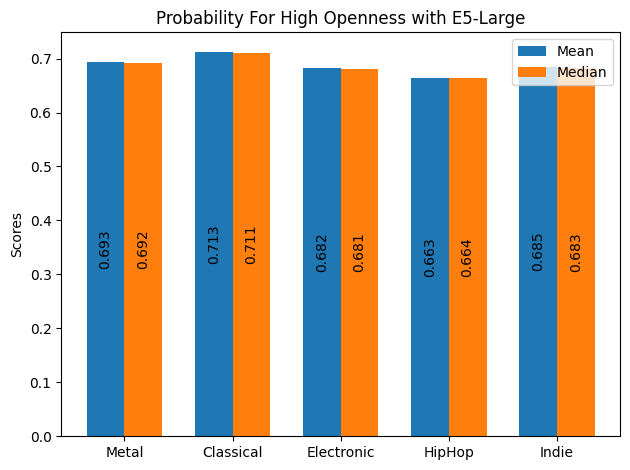

In [15]:
import matplotlib.pyplot as plt
import numpy as np

means = [0.693190, 0.712963, 0.682086, 0.663138, 0.685083]
medians = [0.692388, 0.711178, 0.680727, 0.663928, 0.682996]


def plot_bars_for_high_openness_probability(
    means: list[float], medians: list[float], model_name: str
):
    labels = ["Metal", "Classical", "Electronic", "HipHop", "Indie"]
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, means, width, label="Mean")
    rects2 = ax.bar(x + width / 2, medians, width, label="Median")

    ax.set_ylabel("Scores")
    ax.set_title(f"Probability For High Openness with {model_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                "{:.3f}".format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height / 2),
                xytext=(0, 0),  # no offset
                textcoords="offset points",
                ha="center",
                va="center",
                rotation=90,
            )

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()


plot_bars_for_high_openness_probability(means, medians, model_name="E5-Large")

## `all-MiniLM-L6-v2`


In [ ]:
mean_values = df.groupby("community")[["average_opn_proba_0"]].mean()
median_values = df.groupby("community")[["average_opn_proba_0"]].median()

print("Mean values:")
print(mean_values)

print("\nMedian values:")
print(median_values)

Mean values:
                 average_opn_proba_0  average_opn_proba_1
community                                                
Metal                       0.688614             0.311386
classicalmusic              0.716958             0.283042
electronicmusic             0.684451             0.315549
hiphopheads                 0.681755             0.318245
indieheads                  0.689712             0.310288

Median values:
                 average_opn_proba_0  average_opn_proba_1
community                                                
Metal                       0.688207             0.311793
classicalmusic              0.713479             0.286521
electronicmusic             0.682555             0.317445
hiphopheads                 0.680303             0.319697
indieheads                  0.688481             0.311519


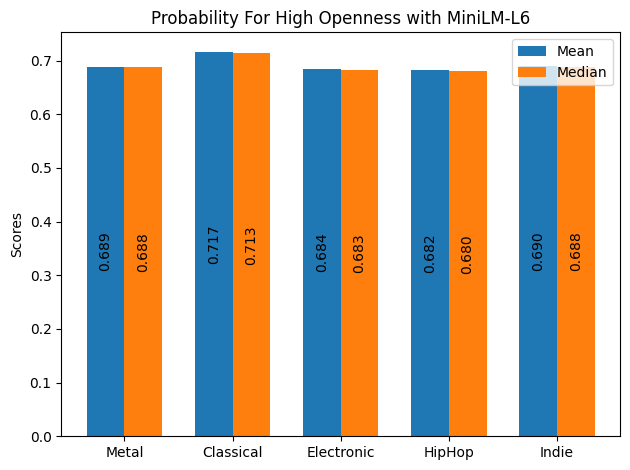

In [48]:
means = [0.688614, 0.716958, 0.684451, 0.681755, 0.689712]
medians = [0.688207, 0.713479, 0.682555, 0.680303, 0.688481]
plot_bars_for_high_openness_probability(means, medians, model_name="MiniLM-L6")

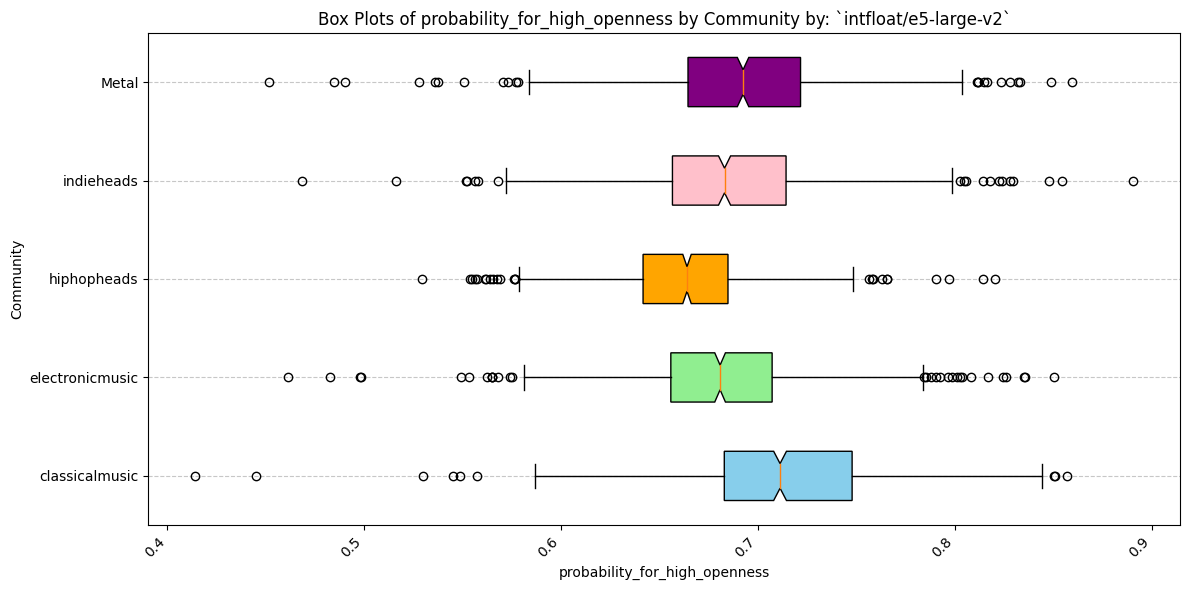

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


def draw_proba_box_plot(class_name: str):
    plt.figure(figsize=(12, 6))

    bp = plt.boxplot(
        [df[df["community"] == c][class_name] for c in df["community"].unique()],
        notch=True,
        vert=False,
        labels=df["community"].unique(),
        patch_artist=True,
    )

    for box, color in zip(
        bp["boxes"], ["skyblue", "lightgreen", "orange", "pink", "purple"]
    ):
        box.set_facecolor(color)

    plt.xlabel(class_name)
    plt.ylabel("Community")
    plt.title(f"Box Plots of {class_name} by Community by: `intfloat/e5-large-v2`")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


draw_proba_box_plot("probability_for_high_openness")

In [16]:
print("Example of the dataframe we have now:")
df.head()

Example of the dataframe we have now:


,community,user_name,#_of_long_texts,probability_for_high_openness,probability_for_high_extroversion
0,classicalmusic,Radaxen,339,0.718496,0.303387
339,classicalmusic,diskoalafied,52,0.762817,0.269692
391,classicalmusic,MantisTobogan-MD,176,0.718637,0.402459
566,classicalmusic,Sommiel,43,0.689825,0.403481
609,classicalmusic,Dangerous_Number_642,20,0.732202,0.377348


# Statistical Tests


## ANOVA

Now that we have ~1K of probability-for-openness score per musical genre community, <br>
we want to understand how significant are the differences between the groups' scores. To do so, we will use the ANOVA test. <br>
ANOVA compares the variance between-groups means to the variance within-groups. If the variance between-groups is larger than the within-groups, it suggests that there are differences in means among the groups.


#### OPN


In [17]:
classicalmusic_df = df[df["community"] == "classicalmusic"]
electronicmusic_df = df[df["community"] == "electronicmusic"]
hiphopheads_df = df[df["community"] == "hiphopheads"]
indieheads_df = df[df["community"] == "indieheads"]
metal_df = df[df["community"] == "Metal"]

opn_data = [
    classicalmusic_df["probability_for_high_openness"],
    electronicmusic_df["probability_for_high_openness"],
    hiphopheads_df["probability_for_high_openness"],
    indieheads_df["probability_for_high_openness"],
    metal_df["probability_for_high_openness"],
]
group_names = ["classical", "electronic", "hiphop", "indie", "metal"]

In [18]:
import scipy.stats as stats


fvalue, pvalue = stats.f_oneway(*opn_data)
print("F-value:", fvalue)
print(
    f"P-value: {pvalue} which is {format(pvalue, '.10f')} when taking only the 10 first digits after the decimal point",
)

F-value: 138.23712889321172
P-value: 8.055153865523848e-112 which is 0.0000000000 when taking only the 10 first digits after the decimal point


#### EXT


In [19]:
classicalmusic_df = df[df["community"] == "classicalmusic"]
electronicmusic_df = df[df["community"] == "electronicmusic"]
hiphopheads_df = df[df["community"] == "hiphopheads"]
indieheads_df = df[df["community"] == "indieheads"]
metal_df = df[df["community"] == "Metal"]

ext_data = [
    classicalmusic_df["probability_for_high_extroversion"],
    electronicmusic_df["probability_for_high_extroversion"],
    hiphopheads_df["probability_for_high_extroversion"],
    indieheads_df["probability_for_high_extroversion"],
    metal_df["probability_for_high_extroversion"],
]
group_names = ["classical", "electronic", "hiphop", "indie", "metal"]

In [20]:
import scipy.stats as stats


fvalue, pvalue = stats.f_oneway(*ext_data)
print("F-value:", fvalue)
print(
    f"P-value: {pvalue} which is {format(pvalue, '.10f')} when taking only the 10 first digits after the decimal point",
)

F-value: 64.82783931750501
P-value: 1.9472193042666866e-53 which is 0.0000000000 when taking only the 10 first digits after the decimal point


## T-Test & Cohen's D Test

**T-Test**: The T-Test is a statistical hypothesis test where the test statistic follows a score's t-distribution under the null hypothesis. It is used to determine whether there is a significant difference between the means of two groups. <br>

**Cohen's d**: Cohen's D is an effect size used to indicate the standardized difference between two means. It's often used in the analysis of t-tests and is considered a good measure of effect size for these tests. It's defined as the difference between two means divided by a standard deviation for the data.

_Note_: A D value of 0.2 is considered a 'small' effect size, 0.5 represents a 'medium' effect size and 0.8 a 'large' effect size. This is just a rule of thumb. The interpretation of d depends on the context.


In [21]:
from scipy import stats
import pingouin as pg
from tabulate import tabulate
from IPython.display import display, HTML


def calculate_cohens_d_and_t_test(data, group_names, second_part_title):
    results = []

    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            t_stat, p_val = stats.ttest_ind(data[i], data[j])
            effect_size = pg.compute_effsize(data[i], data[j])

            # Append the results to the list just for nice tabular representation
            results.append(
                [
                    group_names[i],
                    group_names[j],
                    len(data[i]),
                    len(data[j]),
                    format(t_stat, ".10f"),
                    format(p_val, ".10f"),
                    format(effect_size, ".10f"),
                ]
            )

    table_headers = [
        "Genre 1",
        "Genre 2",
        "Genre 1 # Of Samples",
        "Genre 2 # Of Samples",
        "t-statistic",
        "p-value",
        "Effect Size",
    ]
    table = tabulate(results, headers=table_headers, tablefmt="fancy_grid")
    display(
        HTML(
            f"<h1 style='font-size: 50px;'>T-Test & Cohen's D Tests | {second_part_title} </h1>"
        )
    )

    print(table)


calculate_cohens_d_and_t_test(
    opn_data, group_names, second_part_title="All users - OPN"
)

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │    p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪════════════╪═══════════════╡
│ classical  │ electronic │                    982 │                    886 │      13.2048  │ 0          │     0.611854  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼────────────┼───────────────┤
│ classical  │ hiphop     │                    982 │                    993 │      24.2395  │ 0          │     1.09088   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼────────────┼───────────────┤
│ classical  │ indie      │                    982 │                    871 │      11.5644  │ 0          │     0.538264  │
├────────────┼──

In [22]:
calculate_cohens_d_and_t_test(
    ext_data, group_names, second_part_title="All users - EXT"
)

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │    p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪════════════╪═══════════════╡
│ classical  │ electronic │                    982 │                    886 │    -12.2418   │ 0          │    -0.567232  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼────────────┼───────────────┤
│ classical  │ hiphop     │                    982 │                    993 │    -12.0774   │ 0          │    -0.543535  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼────────────┼───────────────┤
│ classical  │ indie      │                    982 │                    871 │    -11.0455   │ 0          │    -0.514111  │
├────────────┼──

In [23]:
classicalmusic_df.head()

,community,user_name,#_of_long_texts,probability_for_high_openness,probability_for_high_extroversion
0,classicalmusic,Radaxen,339,0.718496,0.303387
339,classicalmusic,diskoalafied,52,0.762817,0.269692
391,classicalmusic,MantisTobogan-MD,176,0.718637,0.402459
566,classicalmusic,Sommiel,43,0.689825,0.403481
609,classicalmusic,Dangerous_Number_642,20,0.732202,0.377348


In [24]:
def filter_data_and_print_stats(
    min_posts=None, column_name="probability_for_high_openness", title_suffix="| OPN"
):
    if not min_posts:
        data = [
            classicalmusic_df[column_name],
            electronicmusic_df[column_name],
            hiphopheads_df[column_name],
            indieheads_df[column_name],
            metal_df[column_name],
        ]
        title = f"All users {title_suffix}"
    else:
        data = [
            classicalmusic_df[
                classicalmusic_df["#_of_long_texts"].astype(int) >= min_posts
            ][column_name],
            electronicmusic_df[
                electronicmusic_df["#_of_long_texts"].astype(int) >= min_posts
            ][column_name],
            hiphopheads_df[hiphopheads_df["#_of_long_texts"].astype(int) >= min_posts][
                column_name
            ],
            indieheads_df[indieheads_df["#_of_long_texts"].astype(int) >= min_posts][
                column_name
            ],
            metal_df[metal_df["#_of_long_texts"].astype(
                int) >= min_posts][column_name],
        ]
        title = f"{min_posts} =< Users' long posts {title_suffix}"
    calculate_cohens_d_and_t_test(data, group_names, title)


filter_data_and_print_stats()
filter_data_and_print_stats(10)
filter_data_and_print_stats(50)
filter_data_and_print_stats(100)

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │    p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪════════════╪═══════════════╡
│ classical  │ electronic │                    982 │                    886 │      13.2048  │ 0          │     0.611854  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼────────────┼───────────────┤
│ classical  │ hiphop     │                    982 │                    993 │      24.2395  │ 0          │     1.09088   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼────────────┼───────────────┤
│ classical  │ indie      │                    982 │                    871 │      11.5644  │ 0          │     0.538264  │
├────────────┼──

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │     p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═════════════╪═══════════════╡
│ classical  │ electronic │                    870 │                    700 │     15.4872   │ 0           │     0.786346  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ hiphop     │                    870 │                    912 │     26.6707   │ 0           │     1.26396   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ indie      │                    870 │                    692 │     14.4565   │ 0           │     0.736362  │
├───────

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │     p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═════════════╪═══════════════╡
│ classical  │ electronic │                    695 │                    478 │     14.188    │ 0           │     0.843068  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ hiphop     │                    695 │                    659 │     24.3687   │ 0           │     1.32497   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ indie      │                    695 │                    447 │     13.3172   │ 0           │     0.80742   │
├───────

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │     p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═════════════╪═══════════════╡
│ classical  │ electronic │                    549 │                    336 │     11.7777   │ 0           │     0.815784  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ hiphop     │                    549 │                    440 │     19.954    │ 0           │     1.27678   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ indie      │                    549 │                    306 │     11.3291   │ 0           │     0.808226  │
├───────

In [25]:
filter_data_and_print_stats(None, "probability_for_high_extroversion", "| EXT")
filter_data_and_print_stats(10, "probability_for_high_extroversion", "| EXT")
filter_data_and_print_stats(50, "probability_for_high_extroversion", "| EXT")
filter_data_and_print_stats(100, "probability_for_high_extroversion", "| EXT")

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │    p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪════════════╪═══════════════╡
│ classical  │ electronic │                    982 │                    886 │    -12.2418   │ 0          │    -0.567232  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼────────────┼───────────────┤
│ classical  │ hiphop     │                    982 │                    993 │    -12.0774   │ 0          │    -0.543535  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼────────────┼───────────────┤
│ classical  │ indie      │                    982 │                    871 │    -11.0455   │ 0          │    -0.514111  │
├────────────┼──

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │     p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═════════════╪═══════════════╡
│ classical  │ electronic │                    870 │                    700 │    -12.6803   │ 0           │    -0.643831  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ hiphop     │                    870 │                    912 │    -12.6736   │ 0           │    -0.600615  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ indie      │                    870 │                    692 │    -10.6435   │ 0           │    -0.542142  │
├───────

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │     p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═════════════╪═══════════════╡
│ classical  │ electronic │                    695 │                    478 │     -11.0951  │ 0           │     -0.659286 │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ hiphop     │                    695 │                    659 │     -10.0234  │ 0           │     -0.54499  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ indie      │                    695 │                    447 │      -7.08339 │ 0           │     -0.429465 │
├───────

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │     p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═════════════╪═══════════════╡
│ classical  │ electronic │                    549 │                    336 │     -8.74919  │ 0           │    -0.606015  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ hiphop     │                    549 │                    440 │     -7.1414   │ 0           │    -0.45695   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ indie      │                    549 │                    306 │     -5.80687  │ 9e-09       │    -0.414265  │
├───────